In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

# Import Custom Module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

[]

***

In [3]:
from src.utils.sets import (init_image_descriptions_map, init_word2idx, init_idx2word,
                            load_set_images, init_image_descriptions_set, data_generator)
from src.utils.image import load_image
from src.utils.sequence import clean

from src.nn import NeuralImageCaptioning, NICInference

***

## Understanding and formating the data

In [4]:
image_descriptions = init_image_descriptions_map()

image_descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [5]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [6]:
for img_name, descriptions in image_descriptions.items():
    image_descriptions[img_name] = [clean(descr) for descr in descriptions]

In [7]:
image_descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [8]:
vocabulary = set()

for key in image_descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image_descriptions[key]]

In [9]:
vocabulary.update('0')
vocabulary.update(['<START>'])
vocabulary.update(['<END>'])

In [10]:
print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 8767


### Sort the Vocabulary lexically

In [11]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [12]:
word2idx = init_word2idx(vocabulary)
idx2word = init_idx2word(vocabulary)

In [13]:
word2idx['dog']

2224

In [14]:
idx2word[2224]

'dog'

***

## Max Description Length

In [15]:
descriptions = []

for key, val in image_descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [16]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [17]:
max_description_length = len(longets_description.split()) + 2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 37


***

## Train/Dev/Test split

In [18]:
train_images = load_set_images('train')
dev_images = load_set_images('dev')
test_images = load_set_images('test')

print('Train size: {}'.format(len(train_images)))
print('Dev size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dev size: 1000
Test size: 1000


### Init Image->Descriptions Maps

In [19]:
train_image_descriptions = init_image_descriptions_set(train_images, image_descriptions)
dev_image_descriptions = init_image_descriptions_set(dev_images, image_descriptions)
test_image_descriptions = init_image_descriptions_set(test_images, image_descriptions)

print('Train size: {}'.format(len(train_image_descriptions)))
print('Dev size: {}'.format(len(dev_image_descriptions)))
print('Test size: {}'.format(len(test_image_descriptions)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [20]:
train_image_descriptions['2513260012_03d33305cf']

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

***

In [21]:
EMBEDDING_DIM = 300
NUM_HIDDEN_NEURONS = [512, 512]

***

# Model

![NIC_model](../../img/NIC.png)

In [22]:
neural_image_captioning = NeuralImageCaptioning(
    EMBEDDING_DIM, max_description_length, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx).build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


***

## Run

### Callbacks

In [33]:
filepath = '../weights/nic-weights.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=True)

# def on_epoch_end(epoch, log):
#     pass

# lambda_callback = LambdaCallback(on_epoch_end=on_epoch_end)


callbacks = [checkpoint]

In [34]:
neural_image_captioning.model.load_weights('../weights/nic-weights.hdf5')

neural_image_captioning.model.compile(RMSprop(0.0001), loss='categorical_crossentropy')

In [35]:
num_imgs_per_batch = 5

generator = data_generator(
    train_image_descriptions,
    word2idx,
    max_description_length,
    num_imgs_per_batch,
    len(vocabulary),
)
steps = len(train_image_descriptions) // num_imgs_per_batch

neural_image_captioning.model.fit_generator(
    generator=generator,
    steps_per_epoch=steps,
    epochs=1000,
    verbose=True,
    callbacks=callbacks,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
   2/1200 [..............................] - ETA: 5:32:29 - loss: 2.3242

KeyboardInterrupt: 

***

## Dev

In [43]:
import nltk
from PIL import Image

from src.utils.config import IMAGES_DIR


In [44]:
inference = NICInference(neural_image_captioning, word2idx)

In [45]:
def show_img(path_to_img):
    img = Image.open(path_to_img)
    img.load()
    plt.imshow(np.asarray(img, dtype='int32'));

def evaluate(img_id, beam_width=3):
    print('Image ID: {}'.format(img_id))
    print('='*50)
    print()
    img = load_image(img_id)
    
    greedy_hypothesis = inference.greedy_search(img)
    beam_hypothesis = inference.beam_search(img, beam_width=beam_width)
    references = image_descriptions[img_id]

    print('Greedy Search: {}'.format(greedy_hypothesis))
    print('Beam Search: {}'.format(beam_hypothesis))
    print()
    
    print('BLEU score Greedy Search: {}'.format(bleu_score.sentence_bleu(references, greedy_hypothesis)))
    print('BLEU score Beam Search: {}'.format(bleu_score.sentence_bleu(references, beam_hypothesis)))
    print()
    
    print('Greedy Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, greedy_hypothesis)))
    print('Beam Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, beam_hypothesis)))
    
    show_img(IMAGES_DIR+img_id+'.jpg')

Image ID: 2269021076_cefc9af989

Greedy Search: a person in the air
Beam Search: a person in the air

BLEU score Greedy Search: 0.11296362697837742
BLEU score Beam Search: 0.11296362697837742

Greedy Search Hypothesis Log Probabilty: -40.49171829223633
Beam Search Hypothesis Log Probabilty: -40.49171829223633


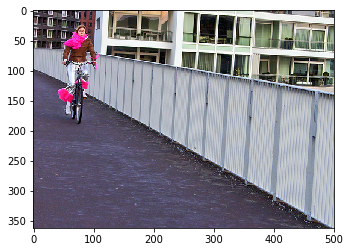

In [46]:

evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=10
)

Image ID: 3476451861_5b9c9ce191

Greedy Search: a person in the air
Beam Search: a person in the air

BLEU score Greedy Search: 0.28607322756210674
BLEU score Beam Search: 0.28607322756210674

Greedy Search Hypothesis Log Probabilty: -40.76622772216797
Beam Search Hypothesis Log Probabilty: -40.76622772216797


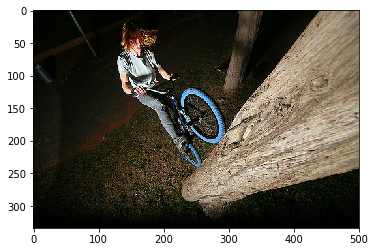

In [47]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=10
)

In [48]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=50
)

Image ID: 2521878609_146143708e



KeyboardInterrupt: 

In [ ]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=50
)

In [ ]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=100
)

In [ ]:
evaluate(
    np.random.choice(list(train_image_descriptions.keys())), beam_width=100
)